In [1]:
import torch
import random
import numpy as np
import json_tricks
import lovely_tensors as lt

lt.monkey_patch()

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

answer = {}

# Training a Fully Connected Feedforward Neural Network

In this exercise we will train a 2-layer FCNN to classify digits into 10 classes (0, 1, 2, ..., 9).

To build such network, we will use:
- Fully Connected NN
- Adam Optimizer
- MNIST dataset
- Accuracy metrics
- Softmax final activation loss function (but we will embed it into the loss function)
- Cross-Entropy loss

# Task 1: Prepare the data

Firstly, prepare MNIST dataset. We will use `torchvision.datasets.MNIST` for that.

You have to download train and test datasets and visualize some of the images.

In [2]:
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST(
    root="./",
    train=True,
    download=True,
    transform=None
)
MNIST_test = torchvision.datasets.MNIST(
    root="./",
    train=False,
    download=True,
    transform=None
)


Check that the data is prepared:

In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.11/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.11/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.11/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.11/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
answer['X_train.dtype'] = str(X_train.dtype)
answer['y_train.dtype'] = str(y_train.dtype)
answer['X_train.shape'] = X_train.shape
answer['X_test.shape'] = X_test.shape
answer['y_train.shape'] = y_train.shape
answer['y_test.shape'] = y_test.shape

print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(X_train)
print(X_test)
print(y_train)
print(y_test)


torch.uint8 torch.uint8 torch.int64 torch.int64
torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28]) torch.Size([60000]) torch.Size([10000])
tensor[60000, 28, 28] u8 n=47040000 (45Mb) x∈[0, 255] μ=33.318 σ=78.567
tensor[10000, 28, 28] u8 n=7840000 (7.5Mb) x∈[0, 255] μ=33.791 σ=79.172
tensor[60000] i64 0.5Mb x∈[0, 9] μ=4.454 σ=2.889
tensor[10000] i64 78Kb x∈[0, 9] μ=4.443 σ=2.896


Neural networks are usually trained in float values. Usually in `float32` or `float16`. In this exercise we will use `float32` precision.

Convert your data to `float` type

In [5]:
X_train = X_train.float()
X_test  = X_test.float()

In [6]:
answer['X_train.dtype2'] = str(X_train.dtype)
answer['X_test.dtype2'] = str(X_test.dtype)


Let us visualize the data that we have

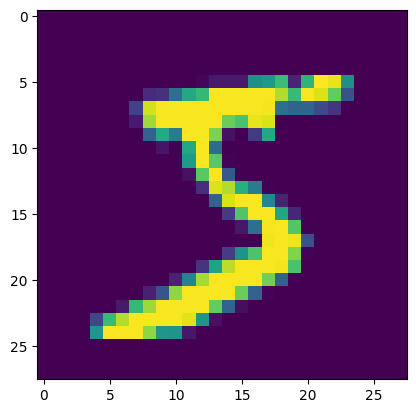

tensor i64 5


In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

Before we continue, our data should be normalized. Right now we have image data that was stored in int8 (from 0 to 255), and after transforming it to float, it still is in the same range.

What we want is the data that has 0 mean and 1 variance.

**Task**
Scale and center your data so that it has 0 mean and 1 variance.

To calculate mean and standard deviation of colors, use only training dataset!

In [8]:
mean = X_train.mean()
std  = X_train.std()

X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std

answer['X_train.mean'] = mean.detach().numpy()
answer['X_train.std'] = std.detach().numpy()

answer['X_train_normalized.mean'] = X_train.mean().detach().numpy()
answer['X_train_normalized.std'] = X_train.std().detach().numpy()

answer['X_test_normalized.mean'] = X_test.mean().detach().numpy()
answer['X_test_normalized.std'] = X_test.std().detach().numpy()

print(X_train)
print(X_test)

tensor[60000, 28, 28] n=47040000 (0.2Gb) x∈[-0.424, 2.822] μ=2.026e-08 σ=1.000
tensor[10000, 28, 28] n=7840000 (30Mb) x∈[-0.424, 2.822] μ=0.006 σ=1.008


Now we should turn our data into vectors to be able to perform forward propagation.

For that we will take the last two dimensions and squeeze them into one. This is done using `reshape` method.

Note that after that tensor can be turned back using reshape command again.

Your initial tensor has shape $N \times 28 \times 28$, you have to turn it to $N \times 28^2$

In [9]:
X_train = X_train.reshape(X_train.size(0), -1)
X_test  = X_test.reshape(X_test.size(0),  -1)


answer['X_train.shape2'] = X_train.shape
answer['X_test.shape2'] = X_test.shape



# Task 2: Build a network

It is time to create our neural network.

In pytorch to enable all the magic for training, people enherit their models from `torch.nn.Module`.

This enables many utilities that will be used in the future.

The main two methods that we have to fill are:
- `__init__` method that creates all modules of Neural Network
- `__call__` method that is used to calculate preditions

Here is the network that you should create:
- it should have the structure:
    - Linear `28 * 28 -> n_hidden_neurons`
    - Sigmoid
    - Linear `n_hidden_neurons -> 10`
- the signals that you create should traverse the initialized modules according to the order above

Note that in theory, we should use a SoftMax activation in the end of this network. But in our case, this activation will be joined with the loss function due to mathematical reasons.

In [10]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

    def __call__(self, signal):
        signal = self.fc1(signal)
        signal = self.ac1(signal)
        signal = self.fc2(signal)
        return signal

Let us check that your network actually works

In [11]:
mnist_net = MNISTNet(100)
check_input = torch.randn(10, 28 * 28)
check_output = mnist_net(check_input)\

answer['check_result'] = check_output.detach().numpy()

# Task 3: Create loss function and optimizer



Now you have to make a loss function (Cross Entropy with SoftMax in our case) and an optimizer (`AdamW` with learning rate `lr`)

In [12]:
loss      = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mnist_net.parameters(), lr=1e-3)


In [13]:
answer['loss'] = str(loss)
answer['optimizer'] = str(optimizer)

print(loss)
print(optimizer)

CrossEntropyLoss()
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)


# Task 4: Train the network

Now it is time to train the network

I have already created a small loop that shuffles the data.

Your task is to create a training cycle for one epoch with the following steps:
1. extracts training input and lables from shuffled training data, batch after batch
2. switches the network to training state (`model.train()`)(will be important for batchnorms and some other modules)
2. generates predictions from the training inputs
3. calculates loss function that compares the predictions to the targets
4. do backpropagation
5. make optimization step  with optimizer
6. reset optimizer's gradients
7. switches the network to validation state (`model.eval()`)

After running one epoch, you should:
- make prediction for train and test sets
- calculate accuracy for the predictions for both sets
- calculate loss function for the predictions for both sets

Note that:
- it is important to drop the last deficient batch, but we do not do it in this exercise
- it is easy to get the class using the prediction vector as it corresponds to the output value with maximal logit

In [14]:
from tqdm import trange

batch_size = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mnist_net = mnist_net.to(device)

test_accuracy_history = []
test_loss_history = []

train_accuracy_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in trange(5):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        end_index = start_index + batch_size
        batch_idx = order[start_index:end_index]

        batch_X = X_train[batch_idx].to(device)
        batch_y = y_train[batch_idx].to(device)

        mnist_net.train()
        preds = mnist_net(batch_X)
        l = loss(preds, batch_y)

        optimizer.zero_grad() 
        l.backward()       
        optimizer.step()      

    
    mnist_net.eval()
    with torch.no_grad():
        train_preds = mnist_net(X_train)
        test_preds  = mnist_net(X_test)

        train_accuracy = (train_preds.argmax(1) == y_train).float().mean()
        test_accuracy  = (test_preds.argmax(1)  == y_test).float().mean()

    train_loss_history.append(loss(train_preds, y_train).detach().numpy())
    train_accuracy_history.append(train_accuracy.detach().numpy())

    test_loss_history.append(loss(test_preds, y_test).detach().numpy())
    test_accuracy_history.append(test_accuracy.detach().numpy())
    

100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


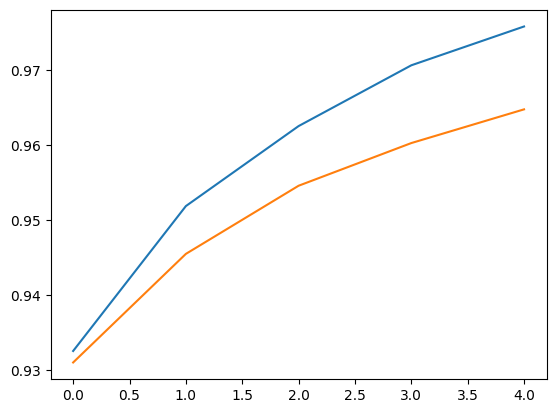

In [15]:
plt.plot(train_accuracy_history)
plt.plot(test_accuracy_history)

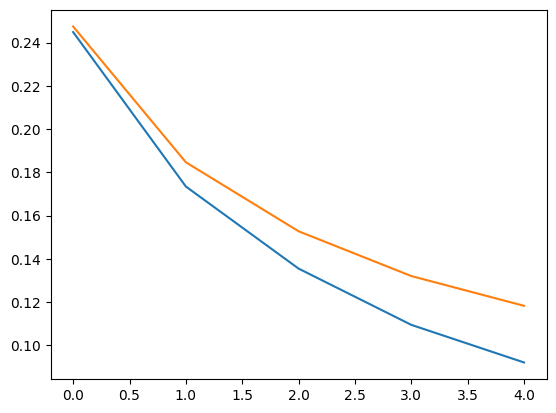

In [16]:
plt.plot(train_loss_history)
plt.plot(test_loss_history)

In [17]:
answer['train_loss_histoory'] = train_loss_history
answer['test_loss_history'] = test_loss_history
answer['train_acc_history'] = train_accuracy_history
answer['test_ann_history'] = test_accuracy_history

json_tricks.dump(answer, '.answer.json')

'{"X_train.dtype": "torch.uint8", "y_train.dtype": "torch.int64", "X_train.shape": [60000, 28, 28], "X_test.shape": [10000, 28, 28], "y_train.shape": [60000], "y_test.shape": [10000], "X_train.dtype2": "torch.float32", "X_test.dtype2": "torch.float32", "X_train.mean": {"__ndarray__": 33.31842041015625, "dtype": "float32", "shape": []}, "X_train.std": {"__ndarray__": 78.56748962402344, "dtype": "float32", "shape": []}, "X_train_normalized.mean": {"__ndarray__": 2.0262010735905278e-08, "dtype": "float32", "shape": []}, "X_train_normalized.std": {"__ndarray__": 1.0, "dtype": "float32", "shape": []}, "X_test_normalized.mean": {"__ndarray__": 0.006017814856022596, "dtype": "float32", "shape": []}, "X_test_normalized.std": {"__ndarray__": 1.0077000856399536, "dtype": "float32", "shape": []}, "X_train.shape2": [60000, 784], "X_test.shape2": [10000, 784], "check_result": {"__ndarray__": [[-0.5284737348556519, -0.28433114290237427, -0.16452449560165405, 0.5217033624649048, 0.12320183962583542, 

# Making the network deep

We have built a network and a training cycle for it. And it works!

In the next exercises we will create all the modules that are required to build deep networks. We will also use batchnormalization in these modules and experiment with them.

# Task 5. Create LinAct block

Create a module that contains `torch.Sequential` module with:
- Linear layer `n_channels -> n_channels`
- Activation function (that is set to `Sigmoid` by default)

Create a module `NoResidual` that is able to wrap a block of the network. It should work just like the original module, and its purpose is that we will replace it with `Residual` block in the future.

After that, create DeepMNISTNet. This network should contain:
- A Linear adapter module to project $28 \times 28$ pixels to `n_channels`
- `n_layers` instances of wrappers, each wrapping 2 sequential `block`-s (with correct number of channels and correct activation function)
- A final classifier linear module that projects the signal of `n_channels` to number of classes (10 in our case)

In [18]:
class LinAct(torch.nn.Module):
    def __init__(self, num_channels, activation_fn=torch.nn.Sigmoid):
        super().__init__()
        self.linear      = torch.nn.Linear(num_channels, num_channels)
        self.activation  = activation_fn()

    def __call__(self, x):
        return self.activation(self.linear(x))




class NoResidual(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.block = module           

    def __call__(self, x):
        return self.block(x)



class DeepMNISTNet(torch.nn.Module):
    def __init__(
        self,
        n_channels,
        n_layers,
        block=LinAct,
        wrapper=NoResidual,
        activation_fn=torch.nn.Sigmoid
    ):
        super().__init__()

        self.adapter = torch.nn.Linear(28 * 28, n_channels)

        self.layers = torch.nn.ModuleList()
        for _ in range(n_layers):
            inner = torch.nn.Sequential(
                block(n_channels, activation_fn),
                block(n_channels, activation_fn)
            )
            self.layers.append(wrapper(inner))
            
        self.classifier = torch.nn.Linear(n_channels, 10)

    def __call__(self, x):
        x = self.adapter(x)
        for layer in self.layers:
            x = layer(x)
        x = self.classifier(x)
        return x

In [19]:
model = DeepMNISTNet(
    n_channels=28*28, 
    n_layers=4)

test_input = torch.zeros([10, 28 * 28])
test_output = model(test_input)

answer['model_deep'] = str(model)
answer['test_output_deep'] = test_output.detach().numpy()

# Task 6

Build a residual wrapper.

This layer should wrap any specified module, and the main idea of it should be that if the module works like $\mathbf f(\mathbf x)$, then wrapped in residual layer, it should work like $\mathbf f(\mathbf x) + \mathbf x$

So, the main question here is how to implement `__call__` method

In [20]:
class Residual(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.block = module         

    def __call__(self, x):
        return self.block(x) + x

In [21]:
model = DeepMNISTNet(
    n_channels=28*28, 
    n_layers=4,
    wrapper=Residual
)

test_input = torch.randn([10, 28 * 28])
test_output = model(test_input)

answer['model_deep_residual'] = str(model)
answer['test_output_deep_residual'] = test_output.detach().numpy()

# Task 7

Build a LinNormAct block that is similar to `LinAct`, but has a normalization module before activation function:
- `torch.nn.Linear`
- `torch.nn.BatchNorm1d`
- activation function

In [22]:
class LinNormAct(torch.nn.Module):
    def __init__(self, num_channels, activation_fn=torch.nn.Sigmoid):
        super().__init__()
        self.linear      = torch.nn.Linear(num_channels, num_channels)
        self.norm        = torch.nn.BatchNorm1d(num_channels)
        self.activation  = activation_fn()

    def __call__(self, x):
        return self.activation(self.norm(self.linear(x)))




model = DeepMNISTNet(
    n_channels=28*28, 
    n_layers=4,
    wrapper=Residual,
    block=LinNormAct
)

test_input = torch.randn([10, 28 * 28])
test_output = model(test_input)

answer['model_deep_residual_linnormact'] = str(model)
answer['test_output_deep_residual_linnormact'] = test_output.detach().numpy()

In [23]:
from pprint import pprint

json_tricks.dump(answer, '.answer.json')

'{"X_train.dtype": "torch.uint8", "y_train.dtype": "torch.int64", "X_train.shape": [60000, 28, 28], "X_test.shape": [10000, 28, 28], "y_train.shape": [60000], "y_test.shape": [10000], "X_train.dtype2": "torch.float32", "X_test.dtype2": "torch.float32", "X_train.mean": {"__ndarray__": 33.31842041015625, "dtype": "float32", "shape": []}, "X_train.std": {"__ndarray__": 78.56748962402344, "dtype": "float32", "shape": []}, "X_train_normalized.mean": {"__ndarray__": 2.0262010735905278e-08, "dtype": "float32", "shape": []}, "X_train_normalized.std": {"__ndarray__": 1.0, "dtype": "float32", "shape": []}, "X_test_normalized.mean": {"__ndarray__": 0.006017814856022596, "dtype": "float32", "shape": []}, "X_test_normalized.std": {"__ndarray__": 1.0077000856399536, "dtype": "float32", "shape": []}, "X_train.shape2": [60000, 784], "X_test.shape2": [10000, 784], "check_result": {"__ndarray__": [[-0.5284737348556519, -0.28433114290237427, -0.16452449560165405, 0.5217033624649048, 0.12320183962583542, 

# Congratulations

Here, obligatory part ends. With it, we have prepared the basic script to train our neural network.

Nevertheless, we can do a lot of interesting experiments now:

- for 100 epochs check, how does the training process go
- check, how does the training process go for `n_layers = 1, 2, 4, 8, 16` 
- for `n_layers=16`, check, whether the network trains with and without residual connections
- for the network with `n_layers=16`, add batch normalization layer, and check how the network trains with and without batch normalization
- additionally, you can make bottleneck blocks out of residual blocks. Check, how much more are they efficient and how much does the quality drop when the size of internal representation is squeezed twice: `N -> N/2 -> N`
- for the best network, add learning rate scheduling such as reduce LR on Plateau
- for the best network, use AdamW with LookAhead (can be found as a separate package)

To run these experiments, just take your training procedure that we have created, and substitute the model with a model of the interest.

With such a simple networks, the experiments potentially can be run on the local machine, but I would recommend uploading this notebook to `Google Colab` and using a GPU (it may cost around 5$/month)

Note that to use `CUDA` for your experiments, you have to
- move model to `cuda` device using `.cuda()` or `.to()` methods
- move batch tensors to `cuda` device the same way

To report your results, you can use matplotlib, but there is a better options for machine learning. There are logging systems for ML that are called:
- tensorboard
- mlflow
- weights and biases
- neptune ai
- and others

I would recommend using the first two and maybe the third one. Tensorboard is a powerful tool to visualize the progress of your training process, while mlflow is a nice tool for journaling the experiments

You can check your solutions submitting your results here:

https://www.kaggle.com/competitions/digit-recognizer